In [6]:
#!/usr/bin/env python
# coding: utf-8
import numpy as np
from keras.callbacks import Callback
from scipy.io import loadmat
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
import itertools
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,Activation
from keras.optimizers import Adam,Nadam
from numpy import linalg as la
from sklearn import preprocessing
from keras import regularizers
import matplotlib.ticker as plticker

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':'1_AXrew2Gh87Kq7Hekj0hNVZv3mrrNoUL'}) # add id
downloaded.GetContentFile('S10.mat')

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



6 classes

In [12]:
electrodes=124
N=32
mat = loadmat("S10.mat")
X_2D = np.array(mat["X_2D"])

#normalization of X_2D
#X = preprocessing.normalize(X_2D)
X = X_2D
#get labels
y = np.array(mat["categoryLabels"]).ravel()

X_training = X[:int(0.8*len(X))]
X_validation = X[int(0.8*len(X)):]

y_training = y[:int(0.8*len(X))]
y_validation = y[int(0.8*len(X)):]

num_classes = 6
y_training1hot = keras.utils.to_categorical(y_training - 1, num_classes) # We subtract 1 to convert to 0-index
y_validation1hot = keras.utils.to_categorical(y_validation - 1, num_classes)


X_training = np.reshape(X_training, (-1, electrodes, N, 1))
X_validation = np.reshape(X_validation, (-1, electrodes, N, 1))

X_training_pad = np.zeros((X_training.shape[0], 124, 32, 3))

X_training_pad[:X_training.shape[0],:X_training.shape[1],:X_training.shape[2]] = X_training 

X_validation_pad = np.zeros((X_validation.shape[0], 124, 32, 3))

X_validation_pad[:X_validation.shape[0],:X_validation.shape[1],:X_validation.shape[2]] = X_validation
 
traingen = keras.preprocessing.image.ImageDataGenerator().flow(X_training_pad,y_training1hot)
validgen =  keras.preprocessing.image.ImageDataGenerator().flow(X_validation_pad,y_validation1hot)

In [8]:

vgg16_model = keras.applications.vgg16.VGG16(include_top=False,input_tensor=keras.Input(shape=(124, 32,3)))
vgg16_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 124, 32, 3)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 124, 32, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 124, 32, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 16, 128)       147584    
______________________________________________________________

In [9]:
model = Sequential()

for layer in vgg16_model.layers:
  model.add(layer)

model.layers.pop()

for layer in model.layers:
  layer.trainable = False

model.add(Flatten())
model.add(Dense(124,activation="relu"))
model.add(Dense(62,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(6,activation='softmax'))

model.summary()

model.compile(Nadam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 124, 32, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 124, 32, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 8, 128)        0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 31, 8, 256)       

In [10]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [13]:

with tf.device('/device:GPU:0'):
  history = model.fit_generator(traingen,validation_data=validgen,epochs=10,verbose=2)

Epoch 1/10
 - 14s - loss: 1.7979 - accuracy: 0.1584 - val_loss: 1.7901 - val_accuracy: 0.1803
Epoch 2/10
 - 6s - loss: 1.7908 - accuracy: 0.1758 - val_loss: 1.8431 - val_accuracy: 0.1948
Epoch 3/10
 - 6s - loss: 1.7879 - accuracy: 0.1837 - val_loss: 1.7391 - val_accuracy: 0.1967
Epoch 4/10
 - 6s - loss: 1.7824 - accuracy: 0.1994 - val_loss: 1.8510 - val_accuracy: 0.2044
Epoch 5/10
 - 6s - loss: 1.7801 - accuracy: 0.2112 - val_loss: 1.7939 - val_accuracy: 0.1967
Epoch 6/10
 - 6s - loss: 1.7758 - accuracy: 0.2035 - val_loss: 1.8046 - val_accuracy: 0.1986
Epoch 7/10
 - 6s - loss: 1.7722 - accuracy: 0.2071 - val_loss: 1.7530 - val_accuracy: 0.2006
Epoch 8/10
 - 6s - loss: 1.7673 - accuracy: 0.2202 - val_loss: 1.8202 - val_accuracy: 0.2112
Epoch 9/10
 - 6s - loss: 1.7625 - accuracy: 0.2313 - val_loss: 1.8604 - val_accuracy: 0.1803
Epoch 10/10
 - 6s - loss: 1.7582 - accuracy: 0.2332 - val_loss: 1.7517 - val_accuracy: 0.2083


In [15]:
y_validation_predictions = model.predict_generator(validgen, verbose=1)
cnf_matrix1 = confusion_matrix(y_validation-1, np.argmax(y_validation_predictions, axis=1))
cnf_matrix1

33/33 [==============================] - 1s 38ms/step


array([[29, 28, 21, 29, 39, 27],
       [27, 18, 21, 39, 32, 37],
       [24, 29, 15, 32, 33, 40],
       [29, 29, 19, 34, 29, 33],
       [33, 28, 17, 33, 33, 28],
       [29, 27, 23, 26, 37, 30]])

12 classes


In [16]:
mat = loadmat('S10.mat')
X = np.array(mat["X_2D"])
y = np.array(mat["exemplarLabels"]).ravel()

y_hf =[]
X_hf = []
for i in range(0,len(X)):
    if (12 < y[i] < 25):
        y_hf.append(y[i])
        X_hf.append(X[i])

X_hf = np.array(X_hf)
y_hf = np.array(y_hf).ravel()

le = preprocessing.LabelEncoder()
le.fit(y_hf)
y_hf = le.transform(y_hf)

X_training = X_hf[:int(0.8*len(X_hf))]
X_validation = X_hf[int(0.8*len(X_hf)):]

y_training = y_hf[:int(0.8*len(X_hf))]
y_validation = y_hf[int(0.8*len(X_hf)):]

num_classes = 12
y_training1hot = keras.utils.to_categorical(y_training - 1, num_classes) # We subtract 1 to convert to 0-index
y_validation1hot = keras.utils.to_categorical(y_validation - 1, num_classes)

X_training = np.reshape(X_training, (-1, electrodes, N, 1))
X_validation = np.reshape(X_validation, (-1, electrodes, N, 1))

X_training_pad = np.zeros((X_training.shape[0], 124, 32, 3))

X_training_pad[:X_training.shape[0],:X_training.shape[1],:X_training.shape[2]] = X_training 

X_validation_pad = np.zeros((X_validation.shape[0], 124, 32, 3))

X_validation_pad[:X_validation.shape[0],:X_validation.shape[1],:X_validation.shape[2]] = X_validation
 
traingen = keras.preprocessing.image.ImageDataGenerator().flow(X_training_pad,y_training1hot)
validgen =  keras.preprocessing.image.ImageDataGenerator().flow(X_validation_pad,y_validation1hot)

model = Sequential()

for layer in vgg16_model.layers:
  model.add(layer)

model.layers.pop()

for layer in model.layers:
  layer.trainable = False

model.add(Flatten())
model.add(Dense(124,activation="relu"))
model.add(Dense(62,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(12,activation='softmax'))

model.summary()

model.compile(Nadam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

with tf.device('/device:GPU:0'):
  history = model.fit_generator(traingen,validation_data=validgen,epochs=10,verbose=2)

y_validation_predictions = model.predict_generator(validgen, verbose=1)
cnf_matrix2 = confusion_matrix(y_validation-1, np.argmax(y_validation_predictions, axis=1))
cnf_matrix2







Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 124, 32, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 124, 32, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 8, 128)        0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 31, 8, 256)       

array([[ 0,  0,  0,  0,  0,  9,  0,  1,  3,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  9,  0,  0,  5,  0,  0,  0,  1],
       [ 0,  0,  0,  1,  0,  8,  0,  0,  4,  0,  0,  1,  1],
       [ 0,  0,  0,  0,  1,  9,  0,  0,  1,  0,  0,  0,  3],
       [ 0,  0,  0,  1,  0, 11,  0,  0,  2,  0,  0,  0,  1],
       [ 0,  0,  1,  0,  0, 10,  0,  0,  1,  0,  0,  2,  0],
       [ 0,  0,  0,  2,  0,  6,  0,  0,  3,  1,  1,  0,  2],
       [ 0,  0,  1,  1,  0,  7,  0,  0,  3,  0,  0,  1,  1],
       [ 0,  0,  0,  2,  0,  7,  0,  0,  2,  0,  1,  1,  1],
       [ 0,  0,  1,  1,  0,  6,  0,  0,  1,  1,  2,  1,  1],
       [ 0,  0,  0,  1,  0,  8,  0,  0,  1,  0,  0,  0,  4],
       [ 0,  0,  2,  1,  0,  6,  0,  0,  1,  0,  1,  1,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

2 classes

In [20]:
 mat = loadmat('S10.mat')
X = np.array(mat["X_2D"])
y = np.array(mat["exemplarLabels"]).ravel()

y_bin =[]
X_bin = []
for i in range(0,len(X)):
    if (12 < y[i] < 25):
        y_bin.append(0) # 0 for hf
        X_bin.append(X[i])
    elif (60 < y[i]): # 1 for inanimate
        y_bin.append(1)
        X_bin.append(X[i])

X_bin = np.array(X_bin)
y_bin = np.array(y_bin).ravel()


X_training = X_bin[:int(0.8*len(X_bin))]
X_validation = X_bin[int(0.8*len(X_bin)):]

X_training = np.reshape(X_training, (-1, 124, 32, 1))
X_validation = np.reshape(X_validation, (-1, 124, 32, 1))

y_training = y_bin[:int(0.8*len(X_bin))]
y_validation =y_bin[int(0.8*len(X_bin)):]

num_classes = 2

X_training_pad = np.zeros((X_training.shape[0], 124, 32, 3))

X_training_pad[:X_training.shape[0],:X_training.shape[1],:X_training.shape[2]] = X_training 

X_validation_pad = np.zeros((X_validation.shape[0], 124, 32, 3))

X_validation_pad[:X_validation.shape[0],:X_validation.shape[1],:X_validation.shape[2]] = X_validation
 
traingen = keras.preprocessing.image.ImageDataGenerator().flow(X_training_pad,y_training)
validgen =  keras.preprocessing.image.ImageDataGenerator().flow(X_validation_pad,y_validation)

model = Sequential()

for layer in vgg16_model.layers:
  model.add(layer)

model.layers.pop()

for layer in model.layers:
  layer.trainable = False

model.add(Flatten())
model.add(Dense(124,activation="relu"))
model.add(Dense(62,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(1,activation='sigmoid'))

model.summary()

model.compile(Nadam(lr=0.0001),loss=keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

with tf.device('/device:GPU:0'):
  history = model.fit_generator(traingen,validation_data=validgen,epochs=20,verbose=2)

y_validation_predictions = np.round(model.predict_generator(X_validation, verbose=1))
cnf_matrix3 = confusion_matrix(y_validation, y_validation_predictions)



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 124, 32, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 124, 32, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 8, 128)        0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 31, 8, 256)       

ValueError: ignored

In [21]:
y_validation_predictions = np.round(model.predict_generator(validgen, verbose=1)) 
cnf_matrix3 = confusion_matrix(y_validation, y_validation_predictions)

11/11 [==============================] - 1s 48ms/step


In [22]:
cnf_matrix3

array([[96, 78],
       [97, 75]])

72 classes

In [23]:
mat = loadmat('S10.mat')
X_2D = np.array(mat["X_2D"])


X = X_2D
#get labels
y = np.array(mat["exemplarLabels"]).ravel()

X_training = X[:int(0.8*len(X))]
X_validation = X[int(0.8*len(X)):]

y_training = y[:int(0.8*len(X))]
y_validation = y[int(0.8*len(X)):]

num_classes = 72
y_training1hot = keras.utils.to_categorical(y_training - 1, num_classes) # We subtract 1 to convert to 0-index
y_validation1hot = keras.utils.to_categorical(y_validation - 1, num_classes)

X_training = np.reshape(X_training, (-1, electrodes, N, 1))
X_validation = np.reshape(X_validation, (-1, electrodes, N, 1))

num_classes = 72

X_training_pad = np.zeros((X_training.shape[0], 124, 32, 3))

X_training_pad[:X_training.shape[0],:X_training.shape[1],:X_training.shape[2]] = X_training 

X_validation_pad = np.zeros((X_validation.shape[0], 124, 32, 3))

X_validation_pad[:X_validation.shape[0],:X_validation.shape[1],:X_validation.shape[2]] = X_validation
 
traingen = keras.preprocessing.image.ImageDataGenerator().flow(X_training_pad,y_training1hot)
validgen =  keras.preprocessing.image.ImageDataGenerator().flow(X_validation_pad,y_validation1hot)


model = Sequential()

for layer in vgg16_model.layers:
  model.add(layer)

model.layers.pop()

for layer in model.layers:
  layer.trainable = False

model.add(Flatten())
model.add(Dense(124,activation="relu"))
model.add(Dense(124,activation="relu"))
model.add(Dense(124,activation="relu"))
model.add(Dense(72,activation='sigmoid'))

model.summary()

model.compile(Nadam(lr=0.0001),loss=keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

with tf.device('/device:GPU:0'):
  history = model.fit_generator(traingen,validation_data=validgen,epochs=20,verbose=2)

y_validation_predictions = model.predict_generator(validgen, verbose=1)
cnf_matrix4= confusion_matrix(y_validation-1, np.argmax(y_validation_predictions, axis=1))
cnf_matrix4


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 124, 32, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 124, 32, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 8, 128)        0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 31, 8, 256)       

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
np.argmax(y_validation_predictions, axis=1)

array([ 8, 54, 25, ..., 32, 54, 32])

In [25]:
y_validation

array([42, 29,  7, ..., 71, 45, 63], dtype=uint8)

In [26]:
cnf_matrix4

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

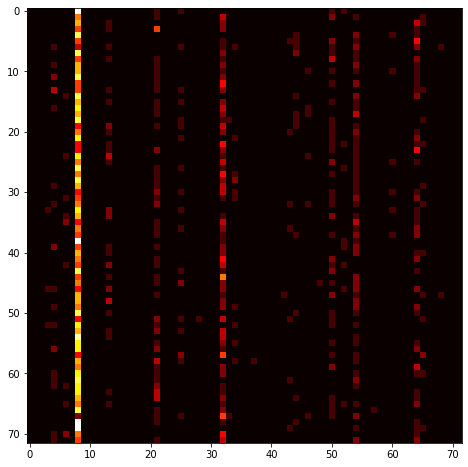

In [27]:
##7##
plt.figure(figsize=(10, 8))
plt.imshow(cnf_matrix4, cmap='hot', interpolation='nearest')
plt.show()

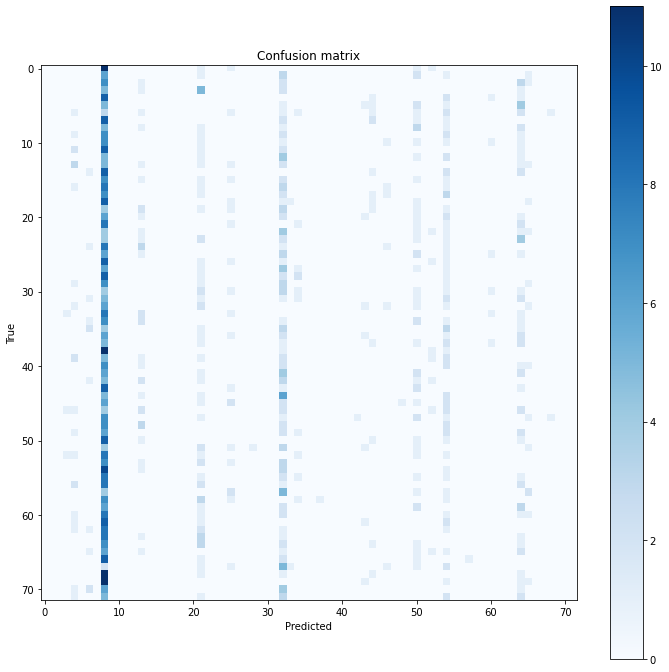

In [28]:
def plot_cm2(cm,n):
    if n != 72:
        fig = plt.figure(figsize=(6.5,6.5))
        ax = fig.add_subplot()
        plt.imshow(cm,cmap='Blues', interpolation='nearest')
        plt.colorbar()
        
        loc = plticker.MultipleLocator(base=1.0)
        ax.xaxis.set_major_locator(loc)
        ax.yaxis.set_major_locator(loc)

        if n == 6 :
            ax.set_xticklabels([''] + ["HB", "HF", "AB", "AF", "FV", "IO"])
            ax.set_yticklabels([''] + ["HB", "HF", "AB", "AF", "FV", "IO"])
        elif n == 12 :
            ax.set_xticklabels([''] + ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
            ax.set_yticklabels([''] + ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
        elif n == 2 :
            ax.set_xticklabels([''] + ["HF", "IO"])
            ax.set_yticklabels([''] + ["HF", "IO"])
    
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment="center",color="white" if cm[i, j] > thresh else "black");
    
    else:
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot()
        plt.imshow(cm,cmap='Blues', interpolation='nearest')
        plt.colorbar()
            
    plt.title("Confusion matrix")
    plt.ylabel('True')
    plt.xlabel('Predicted')
plot_cm2(np.round(cnf_matrix4, 2),72)

Normalized confusion matrix
[[0.16763006 0.16184971 0.12138728 0.16763006 0.22543353 0.15606936]
 [0.15517241 0.10344828 0.12068966 0.22413793 0.18390805 0.21264368]
 [0.13872832 0.16763006 0.0867052  0.1849711  0.19075145 0.23121387]
 [0.16763006 0.16763006 0.10982659 0.19653179 0.16763006 0.19075145]
 [0.19186047 0.1627907  0.09883721 0.19186047 0.19186047 0.1627907 ]
 [0.16860465 0.15697674 0.13372093 0.15116279 0.21511628 0.1744186 ]]
Normalized confusion matrix
[[0.55172414 0.44827586]
 [0.56395349 0.43604651]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Normalized confusion matrix
[[0.         0.         0.         0.         0.         0.64285714
  0.         0.07142857 0.21428571 0.         0.         0.
  0.07142857]
 [0.         0.         0.         0.         0.         0.6
  0.         0.         0.33333333 0.         0.         0.
  0.06666667]
 [0.         0.         0.         0.06666667 0.         0.53333333
  0.         0.         0.26666667 0.         0.         0.06666667
  0.06666667]
 [0.         0.         0.         0.         0.07142857 0.64285714
  0.         0.         0.07142857 0.         0.         0.
  0.21428571]
 [0.         0.         0.         0.06666667 0.         0.73333333
  0.         0.         0.13333333 0.         0.         0.
  0.06666667]
 [0.         0.         0.07142857 0.         0.         0.71428571
  0.         0.         0.07142857 0.         0.         0.14285714
  0.        ]
 [0.         0.         0.         0.13333333 0.         0.4
  0.         0.         0.2        0.06666667 0.06

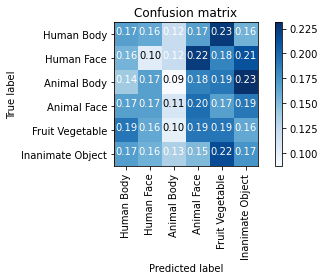

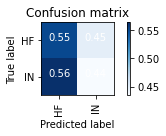

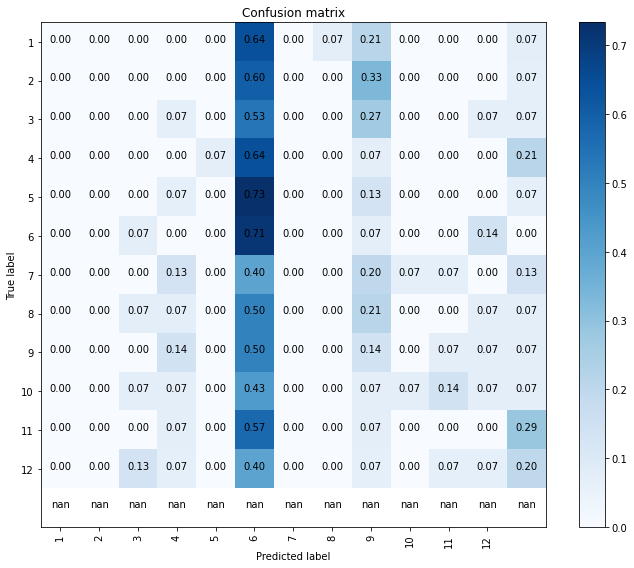

In [30]:
##1##
plt.figure()
class_names = ['Human Body', 'Human Face', 'Animal Body', 'Animal Face', 'Fruit Vegetable', 'Inanimate Object']
plot_confusion_matrix(cnf_matrix1, classes=class_names)


##2##
plt.figure(figsize=(4,2))
class_names = ['HF', 'IN']
plot_confusion_matrix(cnf_matrix3, classes=class_names)

##3##
plt.figure(figsize=(10,8))
class_names = ['1', '2', '3', '4', '5', '6','7', '8', '9', '10', '11', '12']
plot_confusion_matrix(cnf_matrix2, classes=class_names)